# Using ipython cluster with jupyter notebook

## Prerequisites: 
Installed OpenMPI and BlueFog in your system.
Then, you need to setup your jupyter notebook with ipyparallel enabled:
- `pip install jupyter ipyparallel`
- `ipcluster nbextension enable`
- `pip install jupyter_contrib_nbextensions`
- `jupyter contrib nbextension install --user`

## Step 1: Start jupyter notebook
`jupyter notebook`

## Step 2: Start the ipcluster with MPI as engine launcher through the command like
`ipcluster start -n 4 --engines=MPI`

Note: you cannot start with default engine. In that case, BlueFog processes don't know how to communicate with each other.

### (optional) Manually start ipengine
Start the ipcontroller first `ipconfig [--profile=xx]`, then use mpirun to start the ipython engines: `mpirun -np 16 -H machine1:4,machine`

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Connect to client. `rc` is the key to communicate with this notebook (driver) and the clients (workers).
Depending on how many processes you starts, the length of rc will be the same number"

In [2]:
rc = ipp.Client()
rc.ids

[0, 1, 2, 3]

## px magic command

`px` -- parallel execution. `%px` for one line and `%%px` for whole blocks.

The code under the `px` env will be executed into all each worker in parallel instead of running in this notebook.
It is important to rememebr that each worker are one seperated IPython environment as well.

The following is hello-world example to work with bluefog in jupyter notebook, which is already sufficient for most  usage cases. You can find more advanced usage of `px` in the [document page](https://ipyparallel.readthedocs.io/en/latest/magics.html).


In [3]:
%%px
import bluefog.torch as bf

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 2 among 4 processes
[stdout:1] Hello, I am 3 among 4 processes
[stdout:2] Hello, I am 1 among 4 processes
[stdout:3] Hello, I am 0 among 4 processes


# Moving the data/objects between workers and driver

We can easily extract or pass the data between workers and driver.
The key componenet is Direct View class.
Using `dview.push()` and `dview.pull()`, it transmits the data between workers and driver.

In [13]:
%%px
import torch
x = torch.FloatTensor([bf.rank()])

In [78]:
dview = rc[:] # A DirectView of all engines
dview.block=True
x_at_rank0 = dview.pull('x', targets=0)
x_at_rank0

tensor([-0.0547,  0.0653, -0.4044,  0.1698, -0.5502,  0.0987, -0.1377, -0.6541,
        -0.1667, -0.1069], dtype=torch.float64)

In [79]:
xs_at_1_and_2_handle = dview.pull('x', block=False, targets=[1, 2])
xs_at_1_and_2_handle.get()

[tensor([-0.0547,  0.0653, -0.4044,  0.1698, -0.5502,  0.0987, -0.1377, -0.6541,
         -0.1667, -0.1069], dtype=torch.float64),
 tensor([-0.0547,  0.0653, -0.4044,  0.1698, -0.5502,  0.0987, -0.1377, -0.6541,
         -0.1667, -0.1069], dtype=torch.float64)]

In [16]:
# Push the data into all workers
dview.push({'seed': 123}, block=True)

[None, None, None, None, None, None, None, None, None, None, None, None]

In [17]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  123
[stdout:1] I received seed as value:  123
[stdout:2] I received seed as value:  123
[stdout:3] I received seed as value:  123
[stdout:4] I received seed as value:  123
[stdout:5] I received seed as value:  123
[stdout:6] I received seed as value:  123
[stdout:7] I received seed as value:  123
[stdout:8] I received seed as value:  123
[stdout:9] I received seed as value:  123
[stdout:10] I received seed as value:  123
[stdout:11] I received seed as value:  123


# A simple average-consensus example

With px magic command and direct-view, we are good to run and plot a simple average-consensus example

In [18]:
%%px
data_size = 10
torch.random.manual_seed(seed * bf.rank())
max_iters = 100

In [19]:
%%px
x = torch.randn(data_size, dtype=torch.double)
x_bar = bf.allreduce(x, average=True)
mse = [torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2)]
for ite in range(max_iters):
    x = bf.neighbor_allreduce(x, name='x')
    mse.append(torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2))

In [20]:
mse_0 = dview.pull('mse', block=True, targets=0)

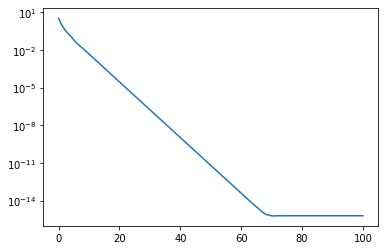

In [21]:
plt.semilogy(mse_0)

[output:0]

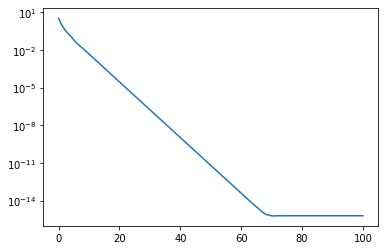

[output:1]

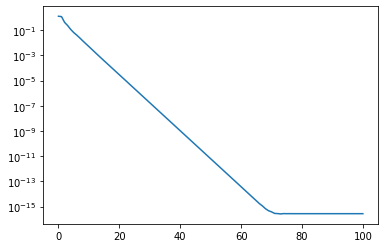

[output:2]

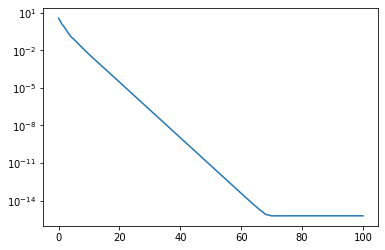

In [22]:
%%px  --targets 0:3
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogy(mse)
plt.show()

# Decentralized training on MNIST with BlueFog

In [35]:
import os
dview.push({'batch_size': 64,
            'test_batch_size': 1000,
            'file_loc': os.path.abspath('')}, block=True)

[None, None, None, None, None, None, None, None, None, None, None, None]

In [36]:
%%px
from bluefog.common import topology_util
import bluefog.torch as bf
import os
import sys

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.distributed
from torchvision import datasets, transforms

# Load data distributed 
data_folder_loc = os.path.join(
    os.path.dirname(file_loc), "..")
train_dataset = datasets.MNIST(
    os.path.join(data_folder_loc, "data", "data-%d" % bf.rank()),
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
)

# Bluefog: use DistributedSampler to partition the training data.
train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset, num_replicas=bf.size(), rank=bf.rank()
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler
)

test_dataset = datasets.MNIST(
    os.path.join(data_folder_loc, "data", "data-%d" % bf.rank()),
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
)
test_sampler = None
# Bluefog: use DistributedSampler to partition the test data.
test_sampler = torch.utils.data.distributed.DistributedSampler(
    test_dataset, num_replicas=bf.size(), rank=bf.rank()
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, sampler=test_sampler
)


In [108]:
%%px
lr = 0.01

# Use LeNet and 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)


model = Net()

# Bluefog: scale learning rate by the number of process.
optimizer = optim.SGD(model.parameters(), lr=lr * bf.size(), 
                      momentum=0.5)

# Bluefog: broadcast parameters & optimizer state.
bf.broadcast_parameters(model.state_dict(), root_rank=0)
bf.broadcast_optimizer_state(optimizer, root_rank=0)

In [109]:
%%px
# Build decentralized ATC optimizer
optimizer = bf.DistributedAdaptThenCombineOptimizer(
                optimizer, 
                model=model,
                communication_type=bf.CommunicationType.neighbor_allreduce)

In [95]:
%%px
# Test the accuracy over all models
def metric_average(val, name):
    tensor = torch.tensor(val)
    avg_tensor = bf.allreduce(tensor, name=name)
    return avg_tensor.item()

def test():
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    for data, target in test_loader:
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        test_accuracy += pred.eq(target.data.view_as(pred)
                                 ).cpu().float().sum().item()

    # Bluefog: use test_sampler to determine the number of examples in
    # this worker's partition.
    test_loss /= len(test_sampler) if test_sampler else len(test_dataset)
    test_accuracy /= len(test_sampler) if test_sampler else len(test_dataset)

    # Bluefog: average metric values across workers.
    test_loss = metric_average(test_loss, "avg_loss")
    test_accuracy = metric_average(test_accuracy, "avg_accuracy")

    # Bluefog: print output only on first rank.
    if bf.rank() == 0:
        print(
            "\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n".format(
                test_loss, 100.0 * test_accuracy
            ), flush=True
        )
    return test_loss, test_accuracy

In [110]:
%%px
# train the model
def train(epoch):
    loss_trace = []
    model.train()
    # Bluefog: set epoch to sampler for shuffling.
    train_sampler.set_epoch(epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx % 10 == 0) and bf.rank() == 0:
            # Bluefog: use train_sampler to determine the number of examples in
            # this worker's partition.
            print(
                "[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    bf.rank(),
                    epoch,
                    batch_idx * len(data),
                    len(train_sampler),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                ), flush=True
            )
            loss_trace.append(loss)
    return loss_trace

By default, the output (like print, stdout, stderr) of worker, i.e. the code in the px block, will be shown in the block after the execution is done. Although there is circumvention through the async mode, it is tricky to write the code. One of the easies solution is to set the control loop in the driver and leave the step of each loop in the `px` env. We use the dview push and pull to transfer the control information.

In [111]:
loss_records = []
test_accuracy = []
test_loss_records = []
for epoch in range(10):
    dview.push({"epoch": epoch}, block=True)
    %px loss_trace = train(epoch)
    %px test_loss, test_accuracy = test()
    loss_records.extend(dview.pull("loss_trace", targets=0, block=True))
    test_loss_records.append(dview.pull("test_loss", targets=0, block=True))
    test_accuracy.append(dview.pull("test_accuracy", targets=0, block=True))

[stdout:0] 
[0] Train Epoch: 0 [0/5000 (0%)]	Loss: 4.189327
[0] Train Epoch: 0 [640/5000 (13%)]	Loss: 3.794176
[0] Train Epoch: 0 [1280/5000 (25%)]	Loss: 3.288463
[0] Train Epoch: 0 [1920/5000 (38%)]	Loss: 3.012653
[0] Train Epoch: 0 [2560/5000 (51%)]	Loss: 2.909175
[0] Train Epoch: 0 [3200/5000 (63%)]	Loss: 2.830475
[0] Train Epoch: 0 [3840/5000 (76%)]	Loss: 2.498777
[0] Train Epoch: 0 [4480/5000 (89%)]	Loss: 2.548792
[stdout:0] 
Test set: Average loss: 4.7473, Accuracy: 93.30%

[stdout:0] 
[0] Train Epoch: 1 [0/5000 (0%)]	Loss: 2.654948
[0] Train Epoch: 1 [640/5000 (13%)]	Loss: 2.646918
[0] Train Epoch: 1 [1280/5000 (25%)]	Loss: 2.434303
[0] Train Epoch: 1 [1920/5000 (38%)]	Loss: 2.431326
[0] Train Epoch: 1 [2560/5000 (51%)]	Loss: 2.453385
[0] Train Epoch: 1 [3200/5000 (63%)]	Loss: 2.583251
[0] Train Epoch: 1 [3840/5000 (76%)]	Loss: 2.241596
[0] Train Epoch: 1 [4480/5000 (89%)]	Loss: 2.239737
[stdout:0] 
Test set: Average loss: 4.6355, Accuracy: 95.33%

[stdout:0] 
[0] Train Epoch: 2

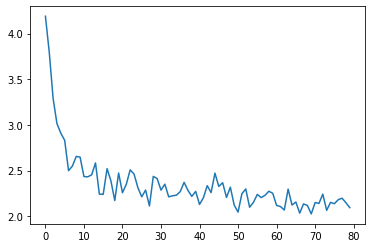

In [112]:
plt.plot(loss_records)

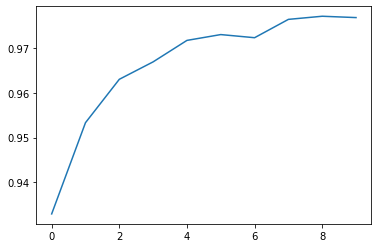

In [113]:
plt.plot(test_accuracy)

## Use Dynamic topology strategy with BlueFog

In [73]:
%%px

# dynamic topology 
dynamic_neighbor_allreduce_gen = topology_util.GetDynamicOnePeerSendRecvRanks(
                bf.load_topology(), bf.rank())

def dynamic_topology_update(epoch, batch_idx):
    send_neighbors, recv_neighbors = next(dynamic_neighbor_allreduce_gen)
    optimizer.send_neighbors = send_neighbors
    optimizer.neighbor_weights = {r: 1/(len(recv_neighbors) + 1) for r in recv_neighbors}
    optimizer.self_weight = 1 / (len(recv_neighbors) + 1)
    optimizer.enable_topo_check = False

# Regenerate model
model = Net()

# Bluefog: scale learning rate by the number of process.
optimizer = optim.SGD(model.parameters(), lr=lr * bf.size(), 
                      momentum=0.5)

# Bluefog: broadcast parameters & optimizer state.
bf.broadcast_parameters(model.state_dict(), root_rank=0)
bf.broadcast_optimizer_state(optimizer, root_rank=0)

# Build decentralized ATC optimizer
optimizer = bf.DistributedAdaptThenCombineOptimizer(
                optimizer, 
                model=model,
                communication_type=bf.CommunicationType.neighbor_allreduce)

# train the model
model.train()
train_loss_record = []
test_loss_record = []
test_accuracy_record = []
for epoch in range(10):
    # Bluefog: set epoch to sampler for shuffling.
    train_sampler.set_epoch(epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        dynamic_topology_update(epoch, batch_idx)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx % 10 == 0) and bf.rank() == 0:
            # Bluefog: use train_sampler to determine the number of examples in
            # this worker's partition.
            print(
                "[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    bf.rank(),
                    epoch,
                    batch_idx * len(data),
                    len(train_sampler),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                ), flush=True
            )
        train_loss_record.append(loss)
    test(test_loss_record, test_accuracy_record)

[stdout:0] 
[0] Train Epoch: 0 [0/5000 (0%)]	Loss: 4.151179
[0] Train Epoch: 0 [640/5000 (13%)]	Loss: 3.741813
[0] Train Epoch: 0 [1280/5000 (25%)]	Loss: 3.470672
[0] Train Epoch: 0 [1920/5000 (38%)]	Loss: 3.155444
[0] Train Epoch: 0 [2560/5000 (51%)]	Loss: 2.838640
[0] Train Epoch: 0 [3200/5000 (63%)]	Loss: 2.944534
[0] Train Epoch: 0 [3840/5000 (76%)]	Loss: 2.778820
[0] Train Epoch: 0 [4480/5000 (89%)]	Loss: 2.540092

Test set: Average loss: 4.7852, Accuracy: 93.13%

[0] Train Epoch: 1 [0/5000 (0%)]	Loss: 2.232374
[0] Train Epoch: 1 [640/5000 (13%)]	Loss: 2.234714
[0] Train Epoch: 1 [1280/5000 (25%)]	Loss: 2.164183
[0] Train Epoch: 1 [1920/5000 (38%)]	Loss: 2.079394
[0] Train Epoch: 1 [2560/5000 (51%)]	Loss: 2.064090
[0] Train Epoch: 1 [3200/5000 (63%)]	Loss: 2.240178
[0] Train Epoch: 1 [3840/5000 (76%)]	Loss: 2.026830
[0] Train Epoch: 1 [4480/5000 (89%)]	Loss: 2.035603

Test set: Average loss: 4.5827, Accuracy: 96.74%

[0] Train Epoch: 2 [0/5000 (0%)]	Loss: 2.042427
[0] Train Epoch:

In [74]:
train_loss_record, test_loss_record, test_accuracy_record = \
    dview.pull(['train_loss_record', 'test_loss_record', 'test_accuracy_record'], targets=0).get()

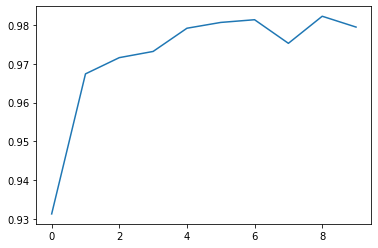

In [77]:
plt.plot(test_accuracy_record)

In [119]:
import time
import ipywidgets

def f(x):
    import time
    time.sleep(.5)
    return x * x

numbers = list(range(100))

def progress_bar(ar):
    # We create a progress bar.
    w = ipywidgets.IntProgress()
    # The maximum value is the number of tasks.
    w.max = len(ar.msg_ids)
    # We display the widget in the output area.
    display(w)
    # Repeat:
    while not ar.ready():
        # Update the widget's value with the
        # number of tasks that have finished
        # so far.
        w.value = ar.progress
        time.sleep(.1)
    w.value = w.max
ar = dview.map_async(f, numbers)

In [92]:
progress_bar(ar)

IntProgress(value=0, max=12)